<a href="https://colab.research.google.com/github/prosvirinKir/Statistical-Natural-Language-Processing/blob/main/assignment_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Information about the submission

## 1.1 Name and number of the assignment

***Enter here** name and number of the assignment*

username: jjjoshbrownnn

task: №1 - WSI

## 1.2 Student name

***Enter here** your Name and Surname in this order*

Joshua Udobang

## 1.3 Codalab user ID

***Enter here** your Codalab user ID used to submit your run to shared task*

## 1.4 Additional comments

***Enter here** any additional comments which you would like to communicate to a TA who is going to grade this work not related to the content of your submission.*

# 2. Technical Report

*Use Section 2 to describe results of your experiments as you would do writing a paper about your results. DO NOT insert code in this part. Only insert plots and tables summarizing results as needed. Use formulas if needed do described your methodology. The code is provided in Section 3.*

## 2.1 Methodology

My method is based on ruBERT from deeppavlov library.

The idea is:


1.   Embedding of target word depends on context in the particular sentence.
2.   Hince, for different contexts we will get the different embeddings.
3.   Because of BERT has his own tokenizer it is not trivial to get the word position.
3.   So, we do like this: $$ \mathrm{input = [cls] + [word] + [sep] + [sentence] + [sep]} $$
3.   In the output we have embeddings and we can extract embedding position of word by $$ \mathrm{word\_mask=[0, 1, 0, 0, 0]} $$ and embedding position of sentence by $$ \mathrm{sent\_mask=[0, 0, 0, 1, 0]} $$









The pipeline is:

1.   Input: word + sentence. Output: embeddings for the whole set of tokens.
1.   Transform output into one embedding.
1.   Do a clastorization in the embeddings space by affinity propagation.



**Without fine tuning:**

1. way: Get the average of the embeddings corresponding to the target word (target word can be split into multiple tokens).
2. way: Get the average of all embeddings in the sentence
3. way: Get the weighted sum of embeddings: $$ \mathrm{word\_emb * 0.8 + sent\_emb * 0.2} $$

This approach shows the good score for *wiki-wiki* dataset, but the bad for *active-dict*.


**Fine tuning:**

In this approach we have some challenge with unknown words in test dataset.
So, we have to fine tuning BERT in such a way that model will be able to collect the important information into embedding of target word. Here is the sheme of how model works:

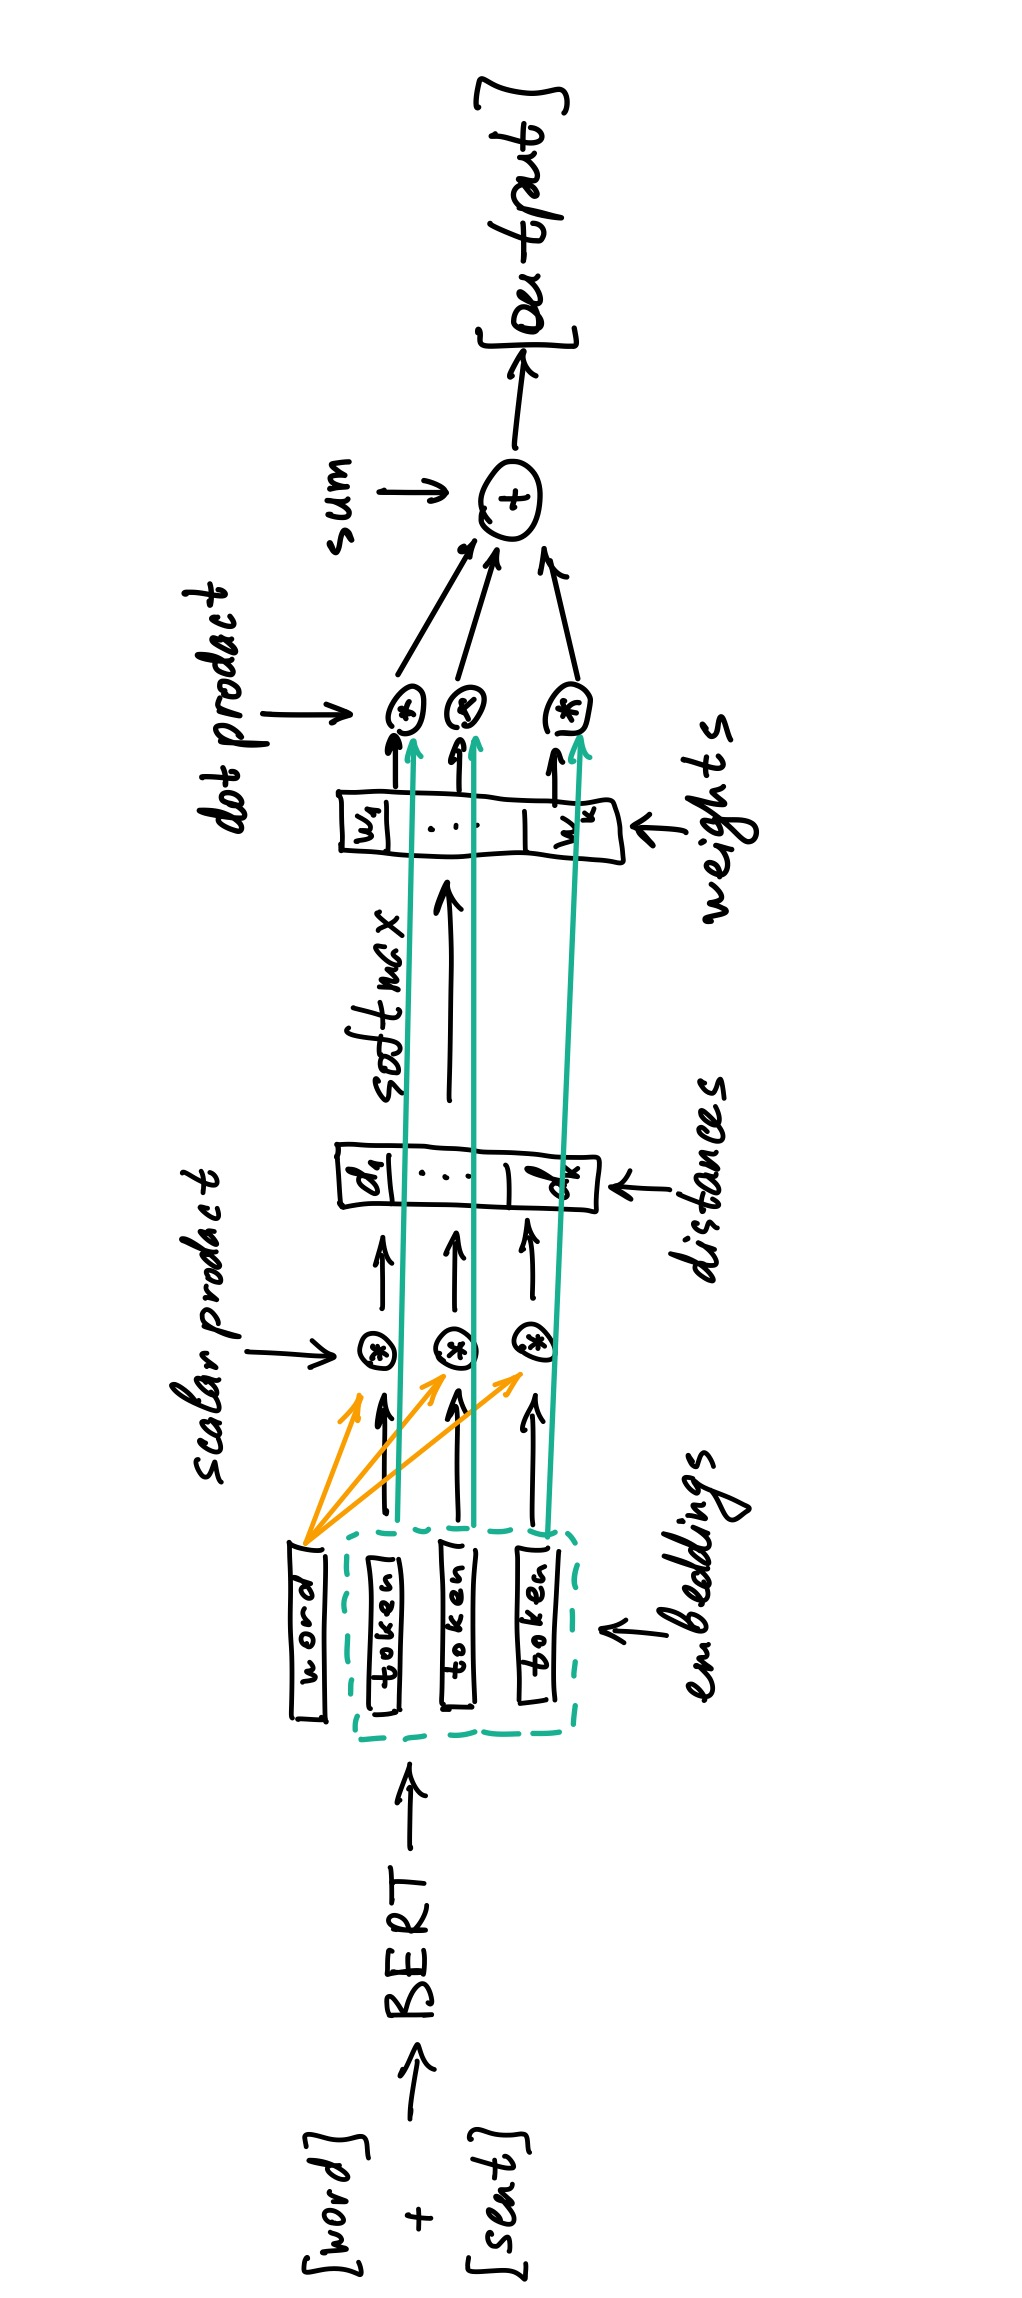

1. Word + sentence is input for BERT.
2. After BERT we have embeddings of all words.
3. Then we want model to know which words in the sentence is important for target word. So, we calculate the scalar prodact betweem target word and other words in the sentence and get the distances between them.
4. After that we do softmax and convert distances into weigths.
5. And finally we calculate weighted sum of all emdeddings of our sentence.
6. Use affinity propagation for clastarisation.

**NOTE:**

1.   During model.eval() output is embedding.
2.   During model.train() output is Linear(768, num_classes).

**Parameters to be tuned:** 1 head, puller, classifier, embedder.

## 2.2 Discussion of results

There were many experiments to know the best parameters to be tuned. I learned the model on one batch and tried to overfit it. So, after a lot of attempts I find that the most relevant parameters is: 1 head, puller, classifier, embedder --- unfreezed.

## BTS

**Fine tuning**

1. Simple way: average of all embeddings in the sentence.


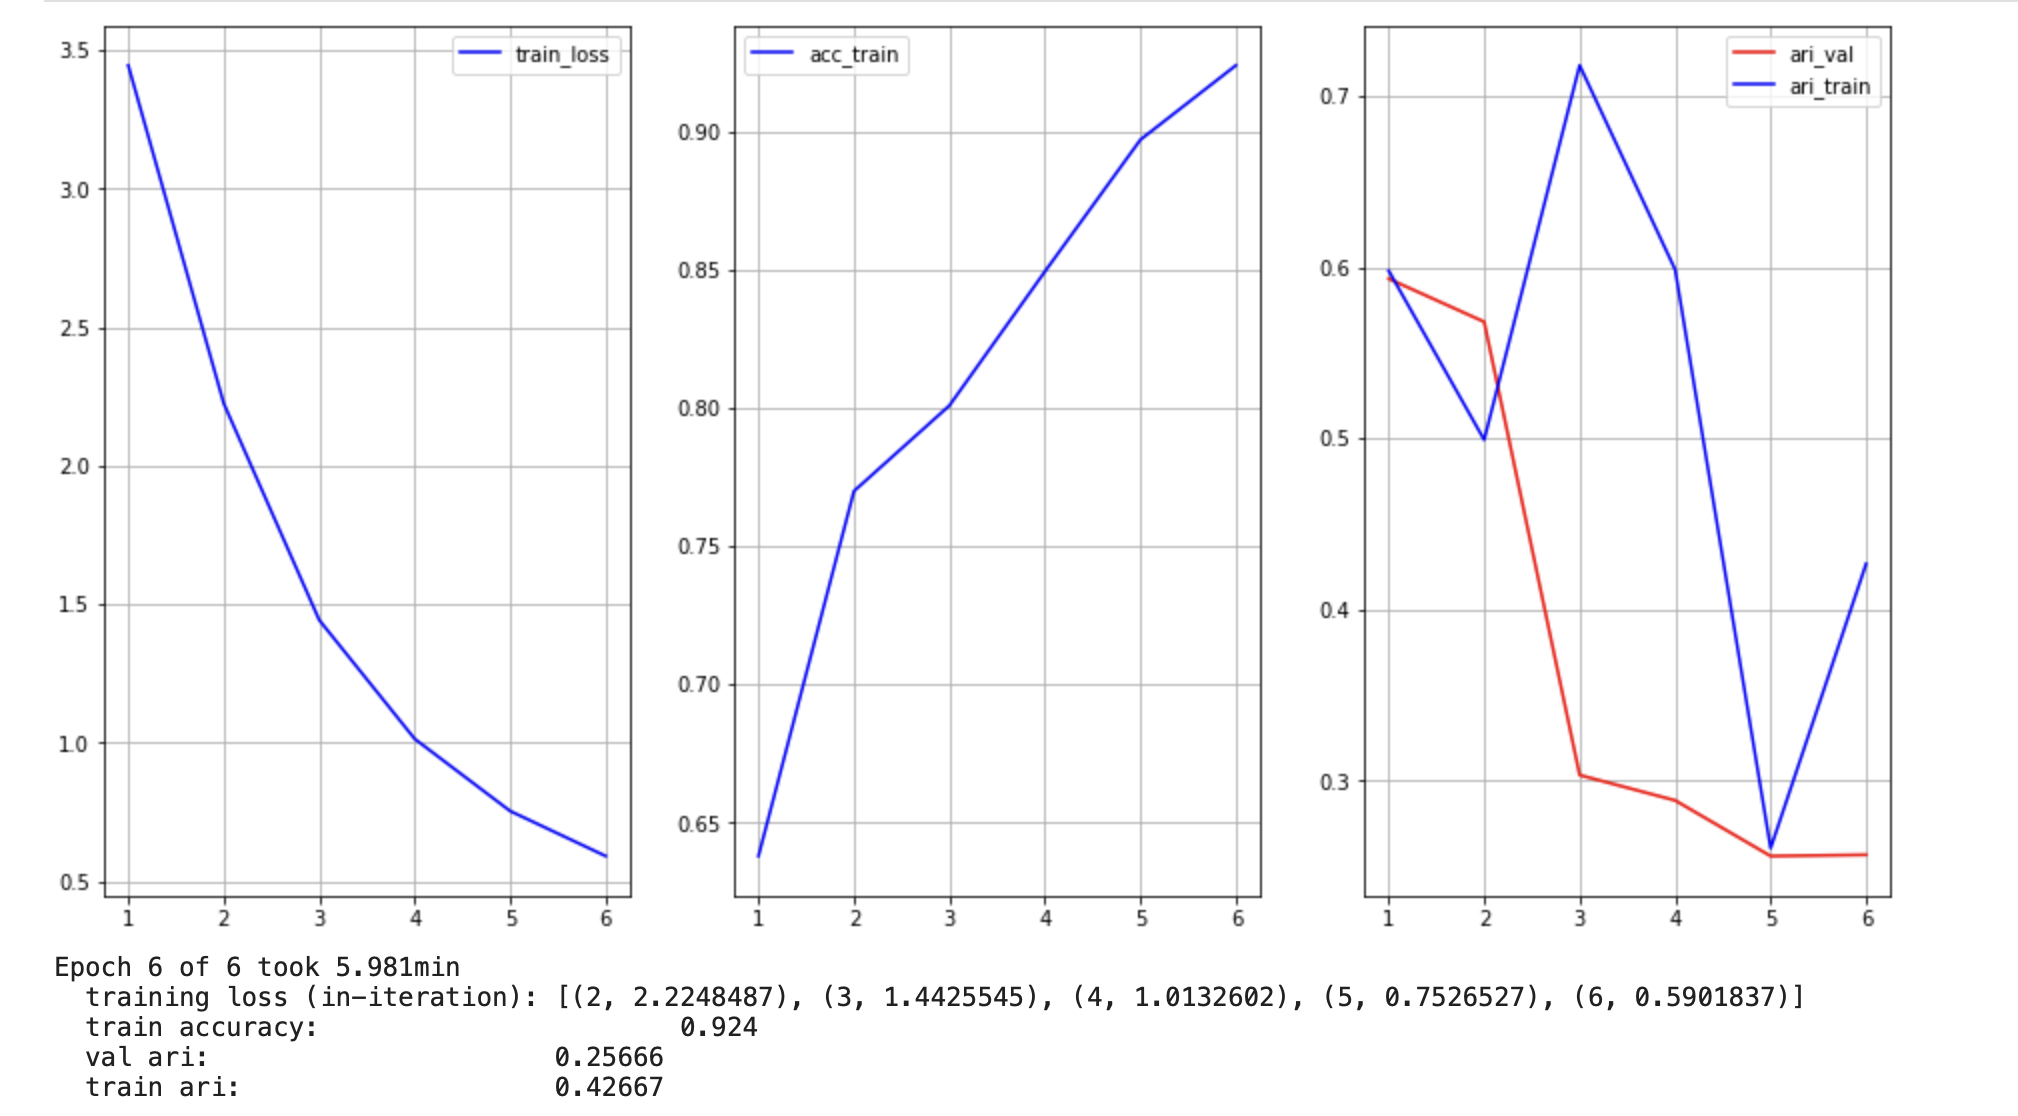

From these plots we can see that model is becoming overfitting despite that fact that score increase.

2. Weighted sum: weight for word token and weight for sentence tokens. Then, embeddings add up with these weights.

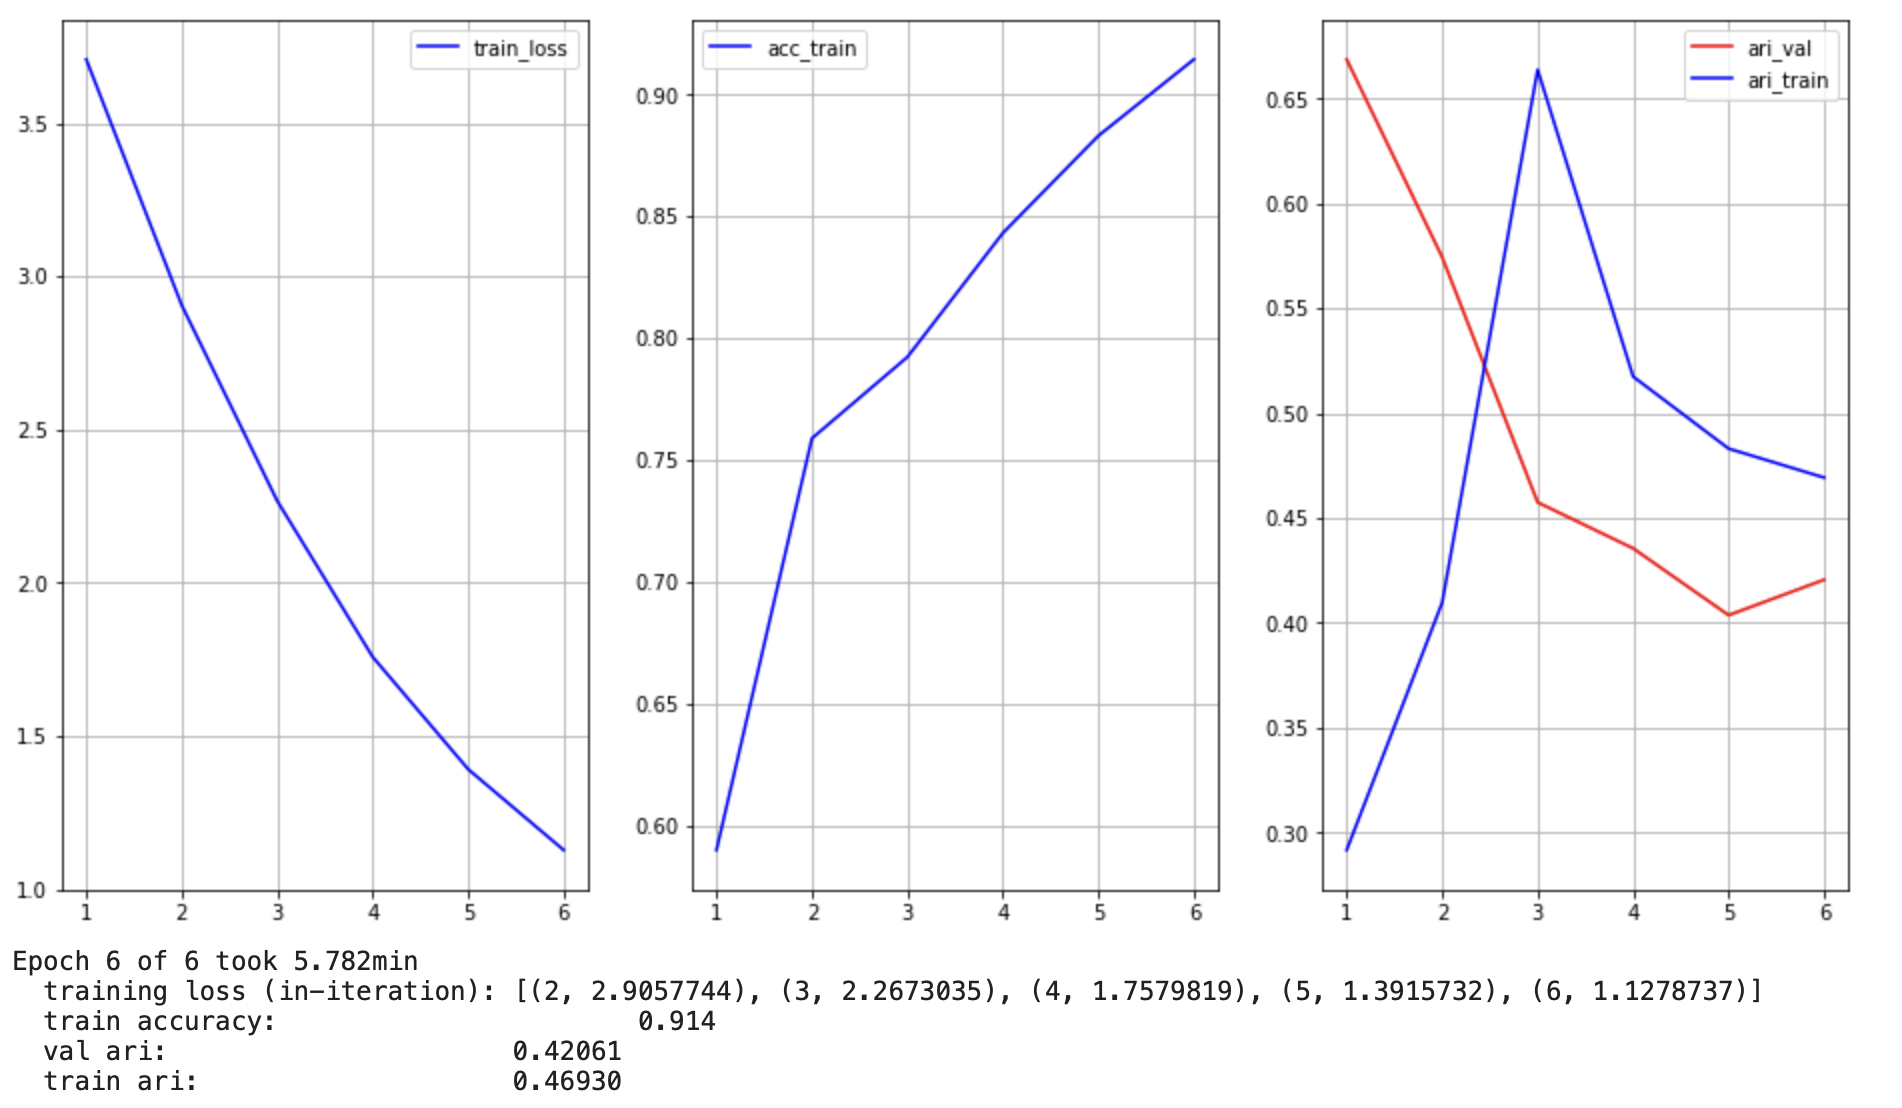

We can see that score is higher compared to the simple method. And it is good:)

## Active dict

**Fine tuning**

1. Complicated way: just like on the picture in paragraph 2.

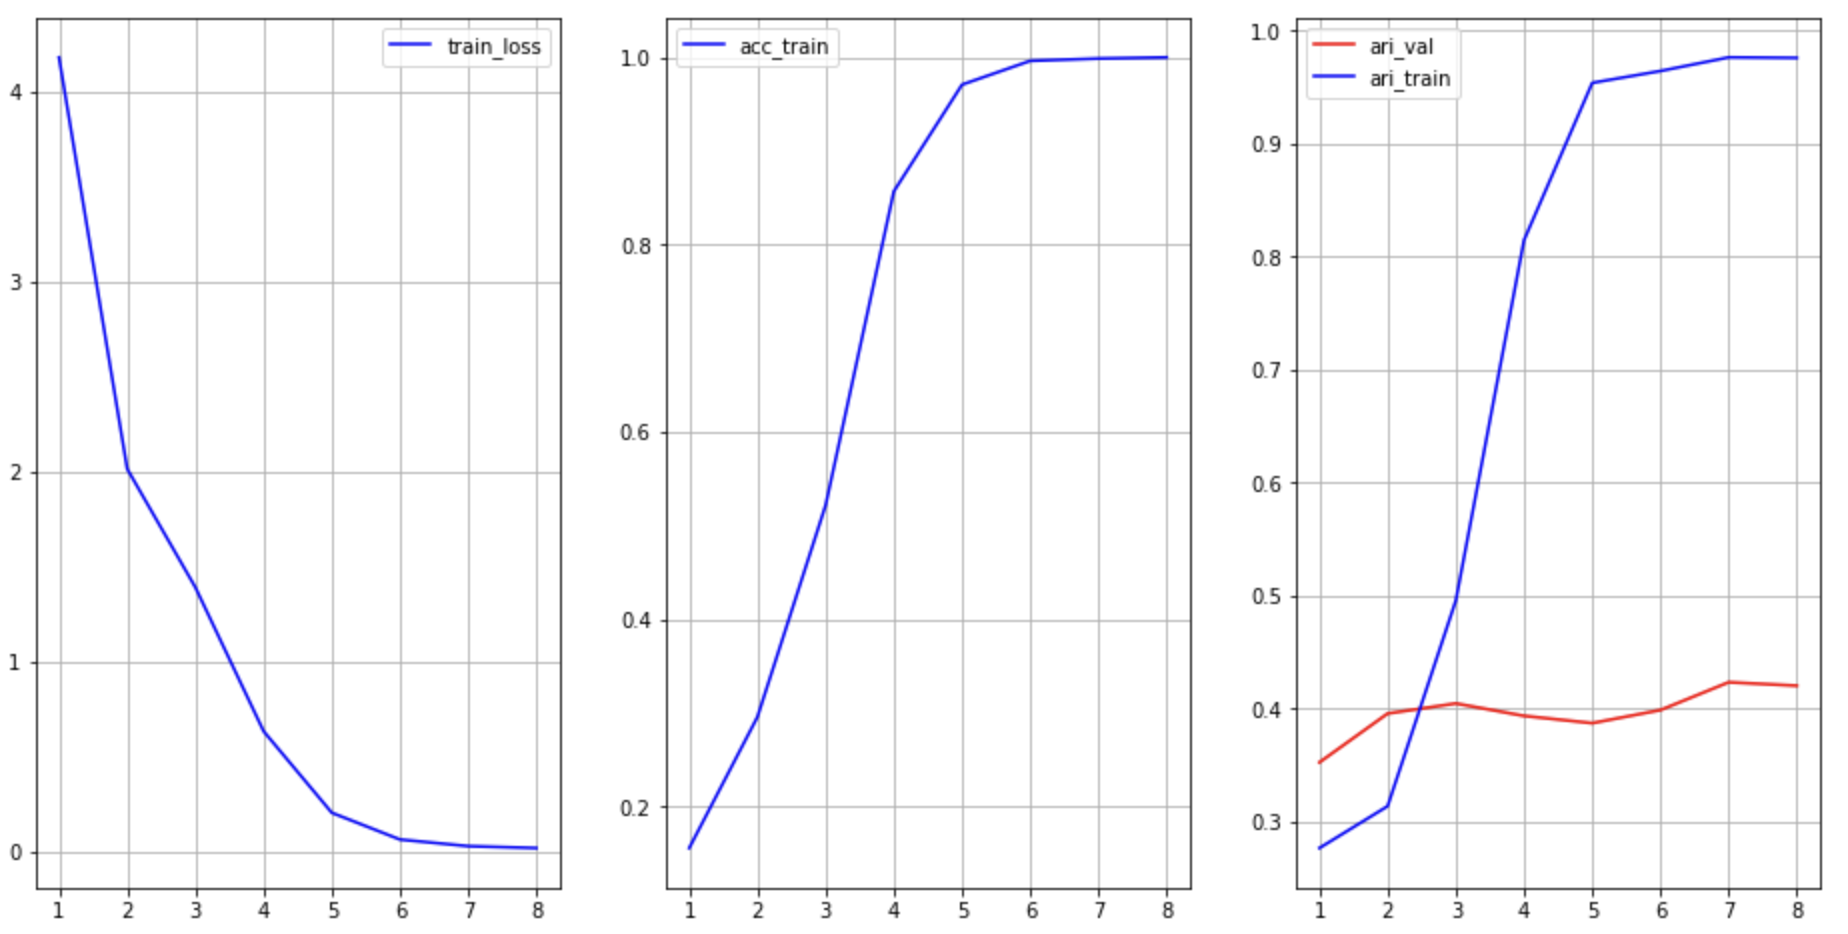

From these plots we can see that model is learning quite well on train dataset and slightly improving on validation dataset. But the baseline has been overcome quite confidently on validation dataset.

# 3. Code

In [ ]:
#!g1.1
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer

from copy import deepcopy

import time
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AffinityPropagation

import pandas as pd

In [ ]:
#!g1.1
def read_data(f_name):
    X_w = []
    X_s = []
    y = []
    pos = []
    with open(f_name) as f:
        head = f.readline().strip().split('\t')
        target_idx = head.index('gold_sense_id')
        word_idx = head.index('word')
        sent_idx = head.index('context')
        pos_idx = head.index('positions')
        while 1:
            s = f.readline().strip().split('\t')
            if not s or s == ['']:
                break
            try:
                X_w.append(s[word_idx])
                X_s.append(s[sent_idx])
                y.append(s[target_idx])
                if len(s[pos_idx]):
                    pos.append([[int(i) for i in j.split('-')] for j in s[pos_idx].split(',')])
                else:
                    pos.append([])
            except:
                print(len(s[pos_idx]), s)
                continue

    return X_w, X_s, y, pos

In [ ]:
#!g1.1
X_w, X_s, y, pos = read_data('wiki-train.csv')

FileNotFoundError: ignored

In [ ]:
#!g1.1
val_ratio = 0.2
train_size = int((1 - val_ratio) * len(X_w))
print(f'train size: {train_size}')
print(f'val size: {len(X_w) - train_size}')

X_train_w = X_w[:train_size]
X_train_s = X_s[:train_size]
y_train = y[:train_size]

X_val_w = X_w[train_size:]
X_val_s = X_s[train_size:]
y_val = y[train_size:]


In [ ]:
#!g1.1
model_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [ ]:
#!g1.1
class magic_dataset(Dataset):
    def __init__(self, words, sentences, target, tokenizer):
        super(magic_dataset, self).__init__()

        self.max_len_w = max([len(tokenizer.encode(x, truncation=True, add_special_tokens=False)) for x in words])
        self.max_len_s = min(max([len(x) for x in sentences]), 500)

        x, word_mask, sent_mask = self._encode(words,
                                          sentences,
                                          tokenizer,
                                          max_len_s=self.max_len_s,
                                          max_len_w=self.max_len_w)

        self.x = x
        self.word_mask = word_mask
        self.sent_mask = sent_mask

        self.target, num_classes = self._make_target(target)
        self.num_classes = num_classes


    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return {'inp': self.x[idx],
                'word_mask': self.word_mask[idx],
                'sent_mask': self.sent_mask[idx],
                'label': self.target[idx]
               }

    def _encode(self, x_w, x_s, t, max_len_s, max_len_w):
        x = []
        word_mask = []
        sent_mask = []
        for w, s in zip(x_w, x_s):
            w_enc = t.encode(w, max_length=self.max_len_w, pad_to_max_length=True, truncation=True, add_special_tokens=False)
            s_enc = t.encode(s, max_length=self.max_len_s, pad_to_max_length=True, truncation=True, add_special_tokens=False)

            x.append(t.build_inputs_with_special_tokens(w_enc, s_enc))
            word_mask.append([0] + [1 if i != 0 else 0 for i in w_enc] + [0]*(len(s_enc) + 2))
            sent_mask.append([0]*(len(w_enc) + 2) + [1 if i != 0 else 0 for i in s_enc] + [0])


        return torch.tensor(x), torch.tensor(word_mask), torch.tensor(sent_mask)

    def _make_target(self, target):
        cur_class = 0
        prev_t = target[0]
        new_target = []

        for t in target:
            if prev_t != t:
                prev_t = t
                cur_class += 1

            new_target.append(cur_class)

        return torch.tensor(new_target), cur_class + 1

In [ ]:
#!g1.1
train_dataset = magic_dataset(X_train_w, X_train_s, y_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = magic_dataset(X_val_w, X_val_s, y_val, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:
#!g1.1
class Model(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(Model, self).__init__()
        self.bert = deepcopy(bert_model)
        self.cls = nn.Linear(768, num_classes)

    def forward(self, inp, word_mask, sent_mask):
        emb = self.bert(inp)[0]
        word_emb = torch.sum(emb.permute((2, 0, 1)) * word_mask, dim=2) / torch.sum(word_mask, dim=1) # (emb, bs, len) * (bs, len) / (bs) = (emb, bs)
        sent_emb = (emb.permute((2, 0, 1)) * sent_mask).permute((2, 0, 1)) # (emb, bs, len) * (bs, len) = (emb, bs, len) -> (len, emb, bs)
        dists = torch.sum(word_emb * sent_emb, dim=1).T # (len, bs) -> (bs, len)
        p = F.softmax(dists, dim=1)
        out = torch.sum(sent_emb.permute((1, 2, 0)) * p, dim=2).T
        out = F.normalize(out, dim=1)

        if self.training:
            return self.cls(out) # (emb, bs, len) * (bs, len) = (emb, bs, len) -> (bs, emb)

        return out

In [ ]:
#!g1.1
def compute_loss(y_pred, y_target):
    return F.cross_entropy(y_pred, y_target)

In [ ]:
#!g1.1
def make_embed(model, embed_dataloader):
    embeds = torch.zeros((1, 768))
    target = torch.zeros((1))

    model.eval()
    for batch in tqdm(embed_dataloader):
        with torch.no_grad():
            inp = batch['inp'].to(device)
            word_mask = batch['word_mask'].to(device)
            sent_mask = batch['sent_mask'].to(device)

            e = model(inp, word_mask, sent_mask).data.cpu()

        embeds = torch.cat([embeds, e], dim=0)
        target = torch.cat([target, batch['label']], dim=0)
    embeds = embeds[1:]
    target = target[1:]

    return F.normalize(embeds), target

In [ ]:
#!g1.1
def eval_model(model, data_loader):

    embeds, target = make_embed(model, data_loader)

    clustering = AffinityPropagation()
    prediction = clustering.fit_predict(embeds.numpy())

    return adjusted_rand_score(target, prediction)

def train_model(model, optimizer, train_dataloader, scheduler):
    train_loss = []
    n_correct = 0
    n_all = 0
    model.train(True)
    for batch in tqdm(train_dataloader, desc='training'):
        optimizer.zero_grad()

        inp = batch['inp'].to(device)
        word_mask = batch['word_mask'].to(device)
        sent_mask = batch['sent_mask'].to(device)
        y_batch = batch['label'].to(device)

        y_pred = model(inp, word_mask, sent_mask) #.data.cpu()
#         print(y_pred)
#         print(y_batch.shape)
        loss = compute_loss(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        n_correct += np.sum((y_batch.cpu() == torch.argmax(F.softmax(y_pred, dim=1).cpu(), dim=1)).numpy())
        n_all += y_batch.shape[0]
        train_loss.append(loss.cpu().data.numpy())
#         break
    if scheduler:
        scheduler.step()
    return n_correct / n_all, np.mean(train_loss)

def train(model, optimizer, train_dataloader, val_dataloader, num_epochs, scheduler):
    train_history = []
    test_history = []
    ari_train_history = []
    ari_val_history = []
    acc_train_history = []
    start_time = time.time()
    for epoch in range(num_epochs):

        accuracy, train_loss = train_model(model, optimizer, train_dataloader, scheduler)
        train_history.append((epoch + 1, train_loss))
        acc_train_history.append((epoch + 1, accuracy))

        ari_val = eval_model(model, val_dataloader)
        ari_val_history.append((epoch + 1, ari_val))

        ari_train = eval_model(model, train_dataloader)
        ari_train_history.append((epoch + 1, ari_train))

        clear_output(True)
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 3, 1)
        plt.plot(*zip(*train_history), color='blue', label='train_loss')
        plt.legend(); plt.grid()

        plt.subplot(1, 3, 2)
        plt.plot(*zip(*acc_train_history), color='blue', label='acc_train')
        plt.legend(); plt.grid()

        plt.subplot(1, 3, 3)
        plt.plot(*zip(*ari_val_history), color='red', label='ari_val')
        plt.plot(*zip(*ari_train_history), color='blue', label='ari_train')
        plt.legend(); plt.grid()
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}min".format(epoch + 1, num_epochs, (time.time() - start_time) / 60))
        print("  training loss (in-iteration): {}".format(train_history[-5:]))

        print("  train accuracy: \t\t\t{:.3f}".format(accuracy))
        print("  val ari: \t\t\t{:.5f}".format(ari_val))
        print("  train ari: \t\t\t{:.5f}".format(ari_train))

In [ ]:
#!g1.1
device = 'cuda'
model = Model(model_bert, train_dataset.num_classes).to(device)
opt = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

num_epochs = 6

In [ ]:
#!g1.1
n_no_grad_layers = 10

for i, c in enumerate(model.bert.encoder.layer.children()):
    if i > n_no_grad_layers:
        break
    for p in c.parameters():
        p.requires_grad = False

In [ ]:
#!g1.1
train(model, opt, train_dataloader, val_dataloader, num_epochs, scheduler)

In [ ]:
#!g1.1
import pandas as pd

def make_prediction(model, tokenizer, file_name, out_file_name, return_embed=True):
    X_w, X_s, y, pos = read_data(file_name)

    dataset = magic_dataset(X_w, X_s, y, tokenizer)
    embed_dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    embeds, target = make_embed(model, embed_dataloader)

    clustering = AffinityPropagation() #-3 - wiki
    prediction = clustering.fit_predict(embeds.numpy())

    df = pd.read_csv(file_name, sep='\t')
    df['predict_sense_id'] = prediction
    df.to_csv(out_file_name, sep='\t')

    print(adjusted_rand_score(target, prediction))


In [ ]:
#!g1.1
make_prediction(model, tokenizer, file_name='test.csv', out_file_name='wiki-test-1.csv')